## Data and Package Importing

In [1]:
import sys
sys.path.append('../')
from QC import *
sc.set_figure_params(dpi=100)

In [2]:
# ignore numba warnings given by sc.pp.neighbors()
import numba; import warnings
warnings.simplefilter('ignore', numba.errors.NumbaWarning); warnings.simplefilter('ignore', numba.errors.NumbaDeprecationWarning); warnings.simplefilter('ignore', numba.errors.NumbaPerformanceWarning)

#### Load data and preprocess

In [3]:
%time s1 = sc.read_h5ad('../data/2771-AS-1-GCCAAT_S1.h5ad') # read in one of the annotated example files

CPU times: user 3.29 s, sys: 538 ms, total: 3.83 s
Wall time: 3.87 s


In [4]:
s1 # see contents of AnnData object

AnnData object with n_obs × n_vars = 8064 × 38459 
    obs: 'ken_filter'

#### Standard preprocessing to get metadata for barcodes:  
* metadata calcs ("total_counts", "pct_counts_mito", etc.)
* transcripts per million (TPM) normalization
* arcsinh and log1p transformation
* 2000 highly variable genes (Seurat-style)

In [5]:
%time recipe_fcc(s1, mito_names="mt-", target_sum=1e6, n_hvgs=2000)

CPU times: user 9.26 s, sys: 2.52 s, total: 11.8 s
Wall time: 11.8 s


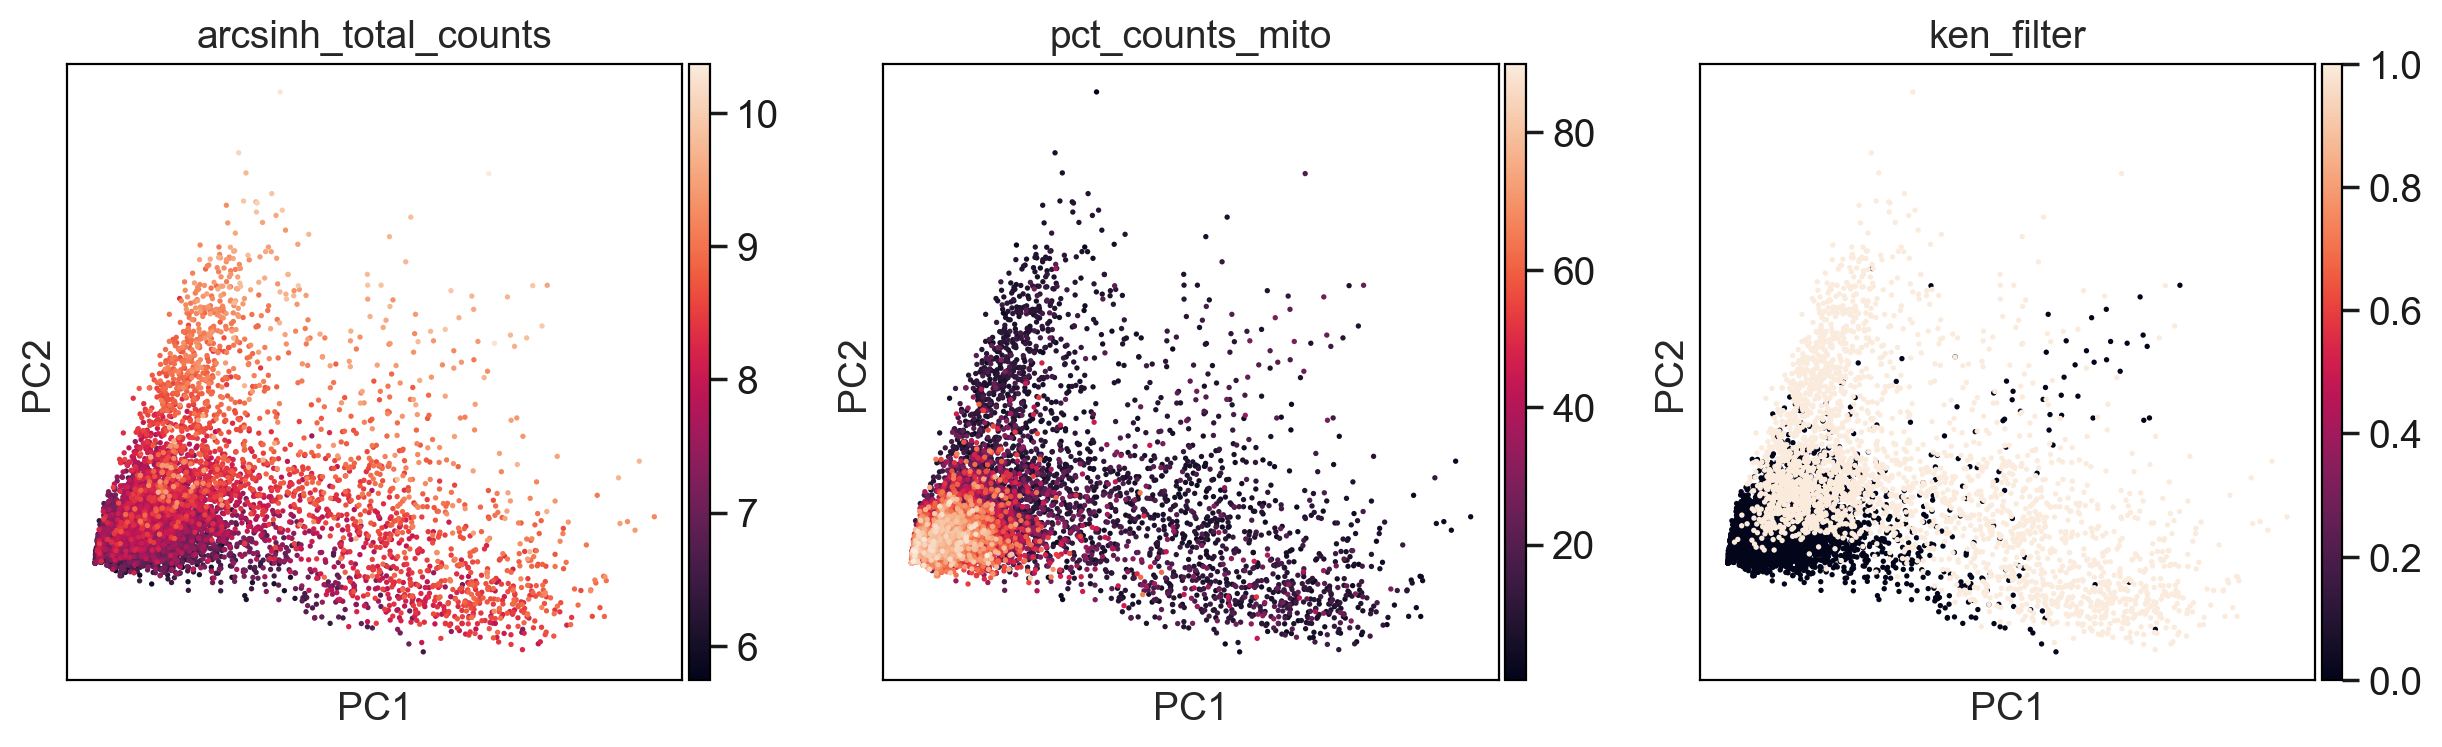

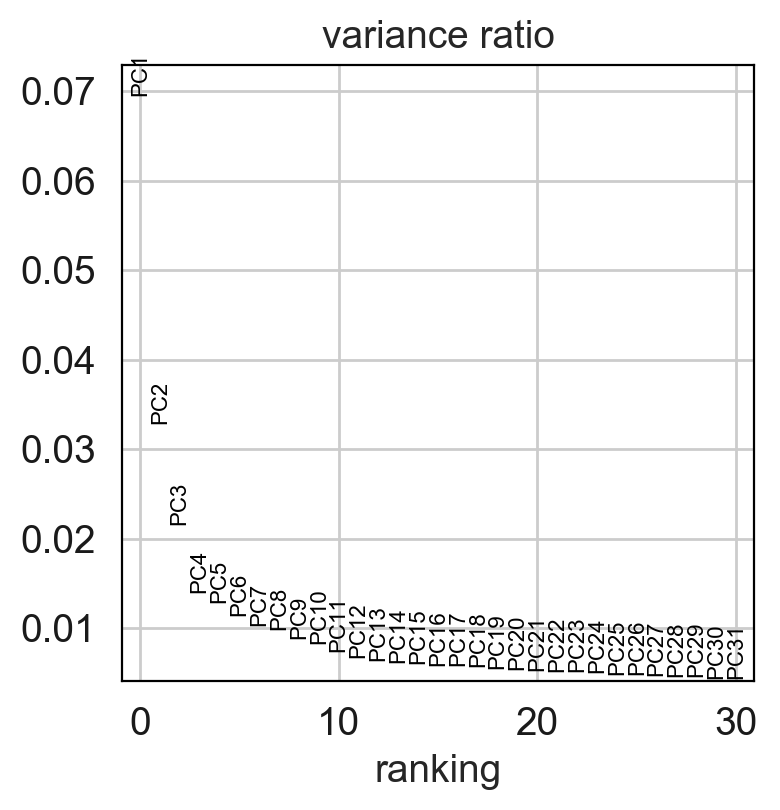

CPU times: user 12.6 s, sys: 1.75 s, total: 14.3 s
Wall time: 3.37 s


In [6]:
%%time
# perform PCA on arcsinh-normalized counts
s1.X = s1.layers['arcsinh_norm'].copy()
sc.tl.pca(s1, n_comps=500)
sc.pl.pca(s1, color=['arcsinh_total_counts','pct_counts_mito','ken_filter'])
sc.pl.pca_variance_ratio(s1)

### Thresholding
Let's try employing automated threshold picking from [scikit-image](https://scikit-image.org/docs/dev/api/skimage.filters.html) to determine the cutoff between our __empty__ and __non-empty__ droplets.

In [7]:
from skimage.filters import threshold_li, threshold_otsu, threshold_mean # popular thresholding methods

In [8]:
# use a few methods on the log-transformed total counts for each barcode:
thresh_counts = threshold_mean(np.array(s1.obs['log1p_total_counts']))
thresh_mito = threshold_mean(np.array(s1.obs['pct_counts_mito']))
thresh_genes = threshold_mean(np.array(s1.obs['log1p_n_genes_by_counts']))

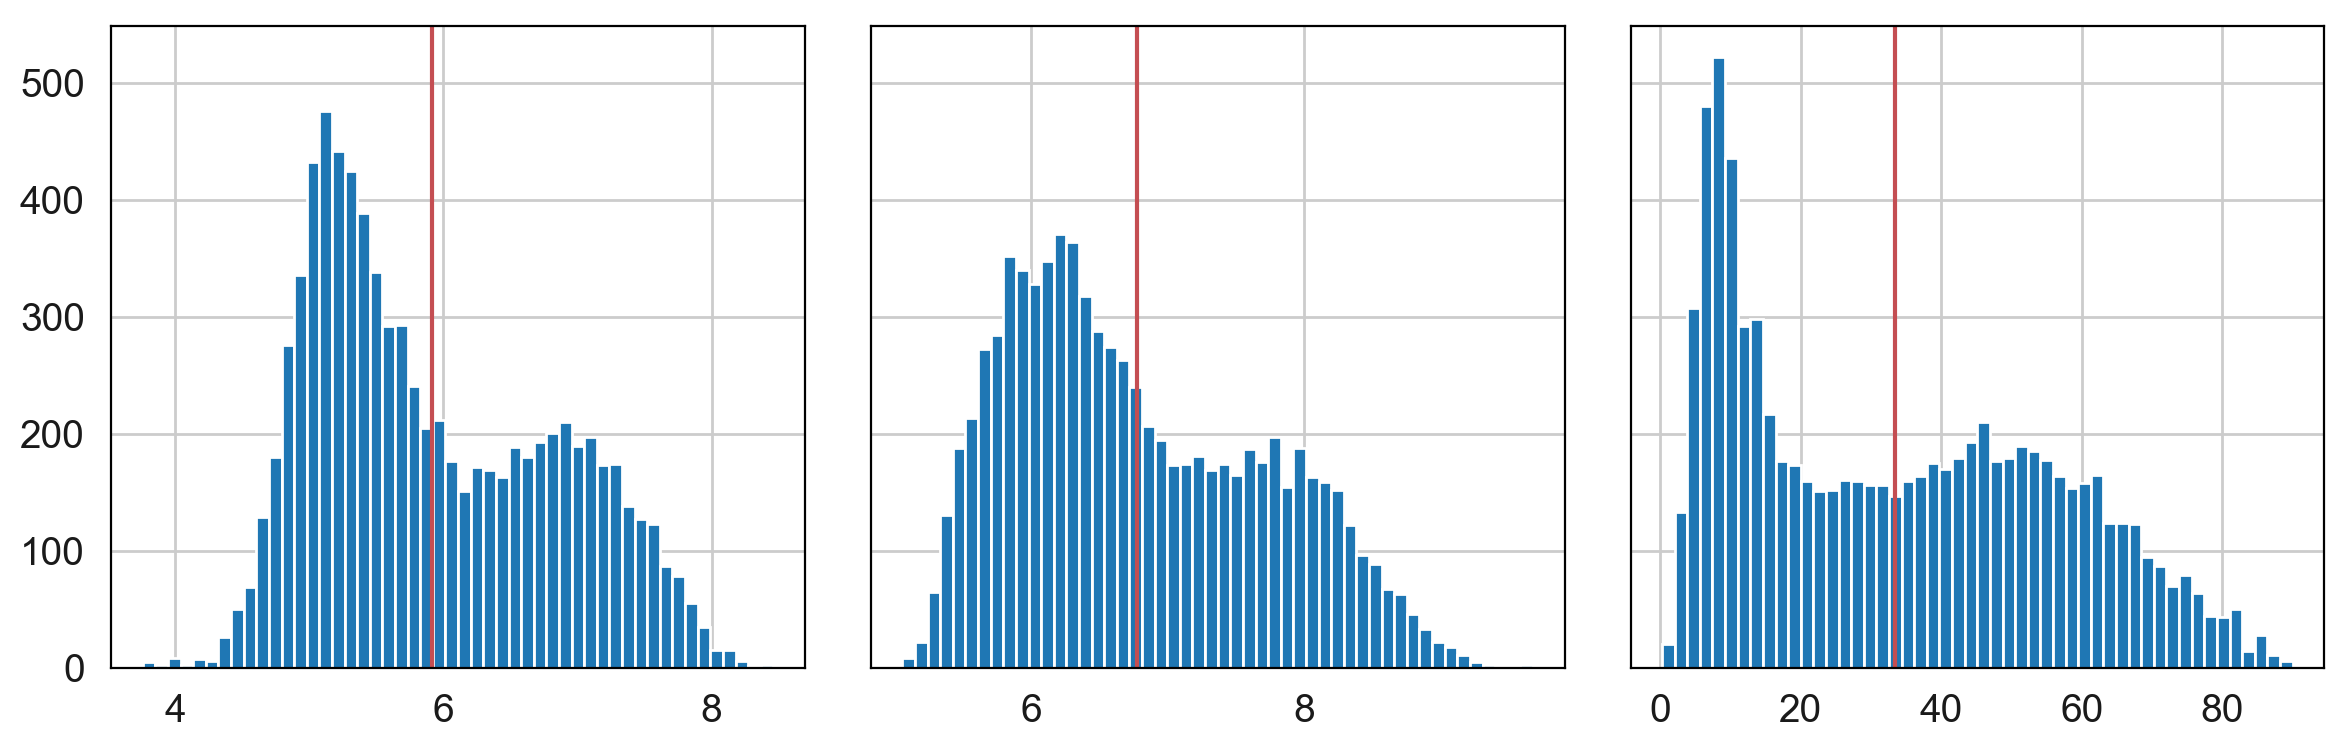

In [9]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,4), sharey=True)
axes[0].hist(s1.obs['log1p_n_genes_by_counts'], bins=50)
axes[0].axvline(thresh_genes, color='r')
axes[1].hist(s1.obs['log1p_total_counts'], bins=50)
axes[1].axvline(thresh_counts, color='r')
axes[2].hist(s1.obs['pct_counts_mito'], bins=50)
axes[2].axvline(thresh_mito, color='r')
plt.tight_layout()

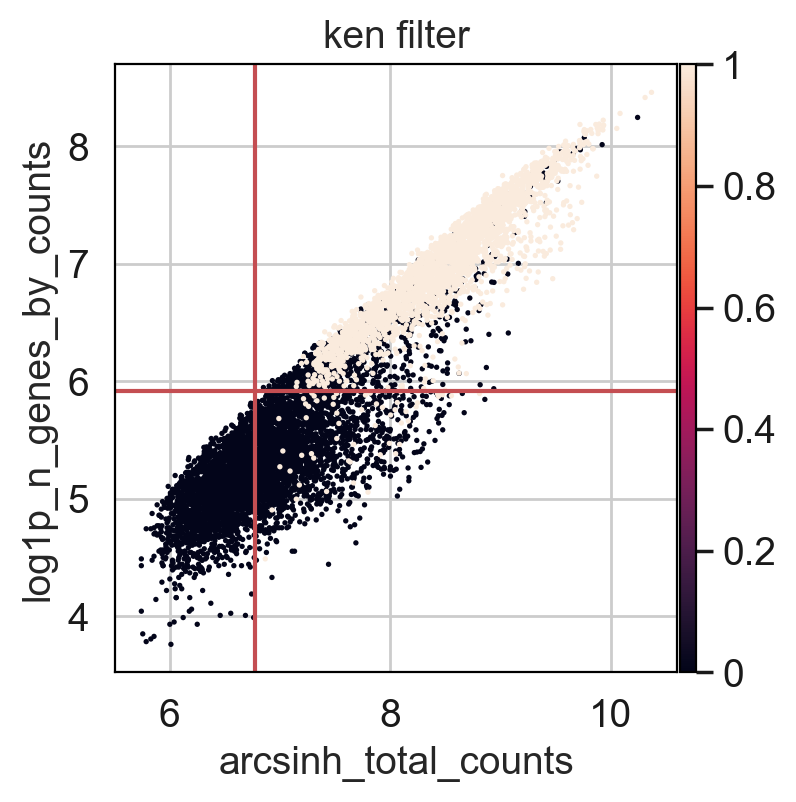

In [10]:
ax = sc.pl.scatter(adata=s1, y='log1p_n_genes_by_counts', x='arcsinh_total_counts', color='ken_filter', show=False)
ax.axvline(thresh_counts, color='r')
ax.axhline(thresh_genes, color='r')
plt.show()

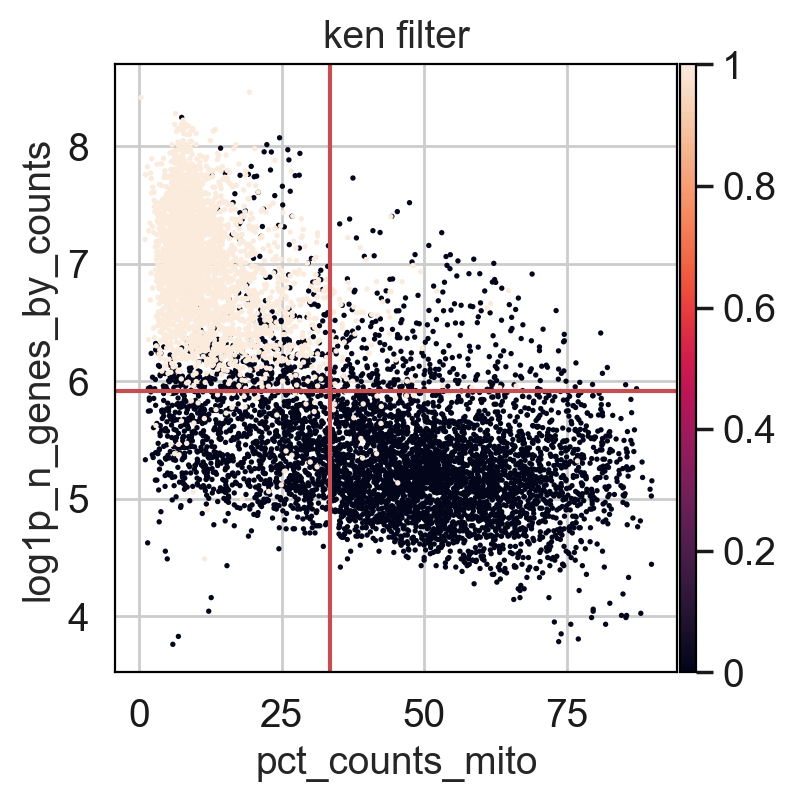

In [11]:
ax = sc.pl.scatter(adata=s1, y='log1p_n_genes_by_counts', x='pct_counts_mito', color='ken_filter', show=False)
ax.axvline(thresh_mito, color='r')
ax.axhline(thresh_genes, color='r')
plt.show()

In [12]:
s1.obs['thresh_filter'] = 0
s1.obs.loc[(s1.obs['log1p_n_genes_by_counts']>=thresh_genes) & (s1.obs['log1p_total_counts']>=thresh_genes) & (s1.obs['pct_counts_mito']<=thresh_mito), 'thresh_filter'] = 1

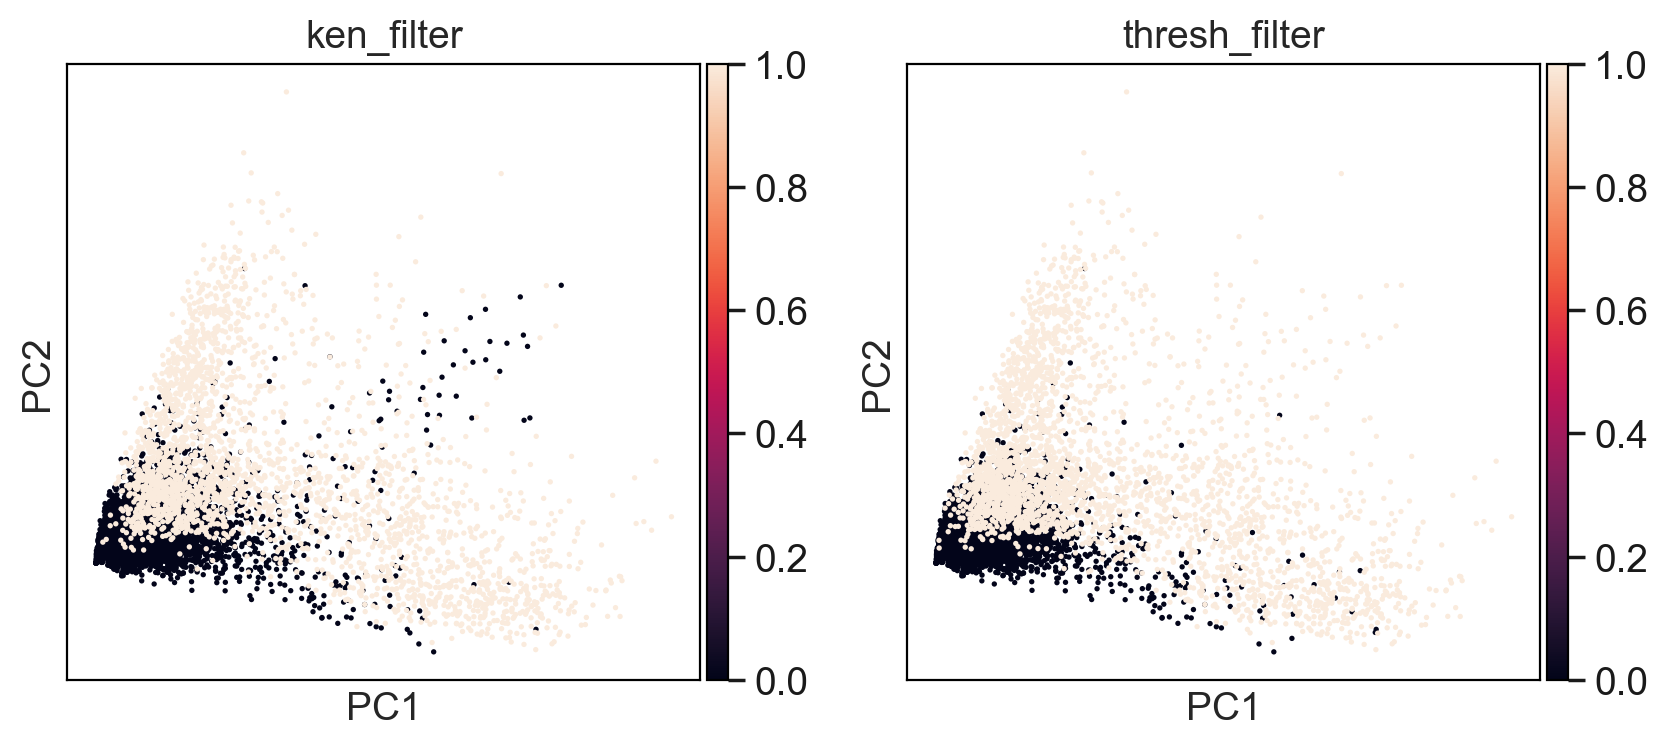

In [13]:
sc.pl.pca(s1, color=['ken_filter','thresh_filter'])

In [14]:
len(set(s1.obs_names[s1.obs['thresh_filter']==1]) ^ set(s1.obs_names[s1.obs['ken_filter']==1]))

573

---
### Ken's Filter

In [15]:
s1_ken = s1[s1.obs['ken_filter']==1,].copy()
s1_ken

AnnData object with n_obs × n_vars = 2715 × 38459 
    obs: 'ken_filter', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'ranked_total_counts', 'arcsinh_total_counts', 'TPM_norm_factor', 'thresh_filter'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw_counts', 'arcsinh_norm', 'log1p_norm'

In [27]:
s1_ken.X = s1_ken.layers['raw_counts'].copy()
recipe_fcc(s1_ken, mito_names="mt-")

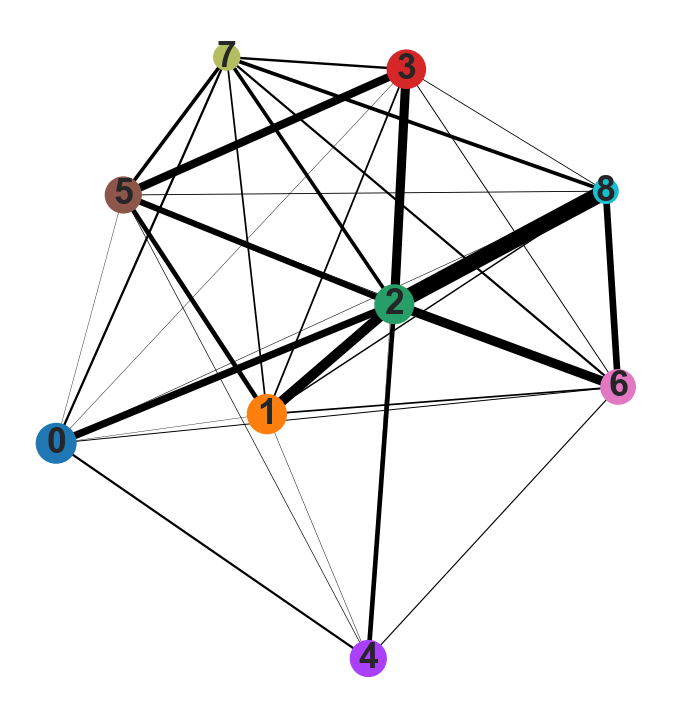

CPU times: user 664 ms, sys: 50.9 ms, total: 715 ms
Wall time: 376 ms


In [29]:
%%time
sc.tl.pca(s1_ken, n_comps=100)
sc.pp.neighbors(s1_ken, n_neighbors=int(round(np.sqrt(s1_ken.n_obs))), use_rep='X_pca', n_pcs=50, random_state=18)
sc.tl.louvain(s1_ken, random_state=18)
sc.tl.paga(s1_ken)
sc.pl.paga(s1_ken, frameon=False)

In [32]:
sc.tl.umap(s1_ken, init_pos=sc.tl._utils.get_init_pos_from_paga(s1_ken))

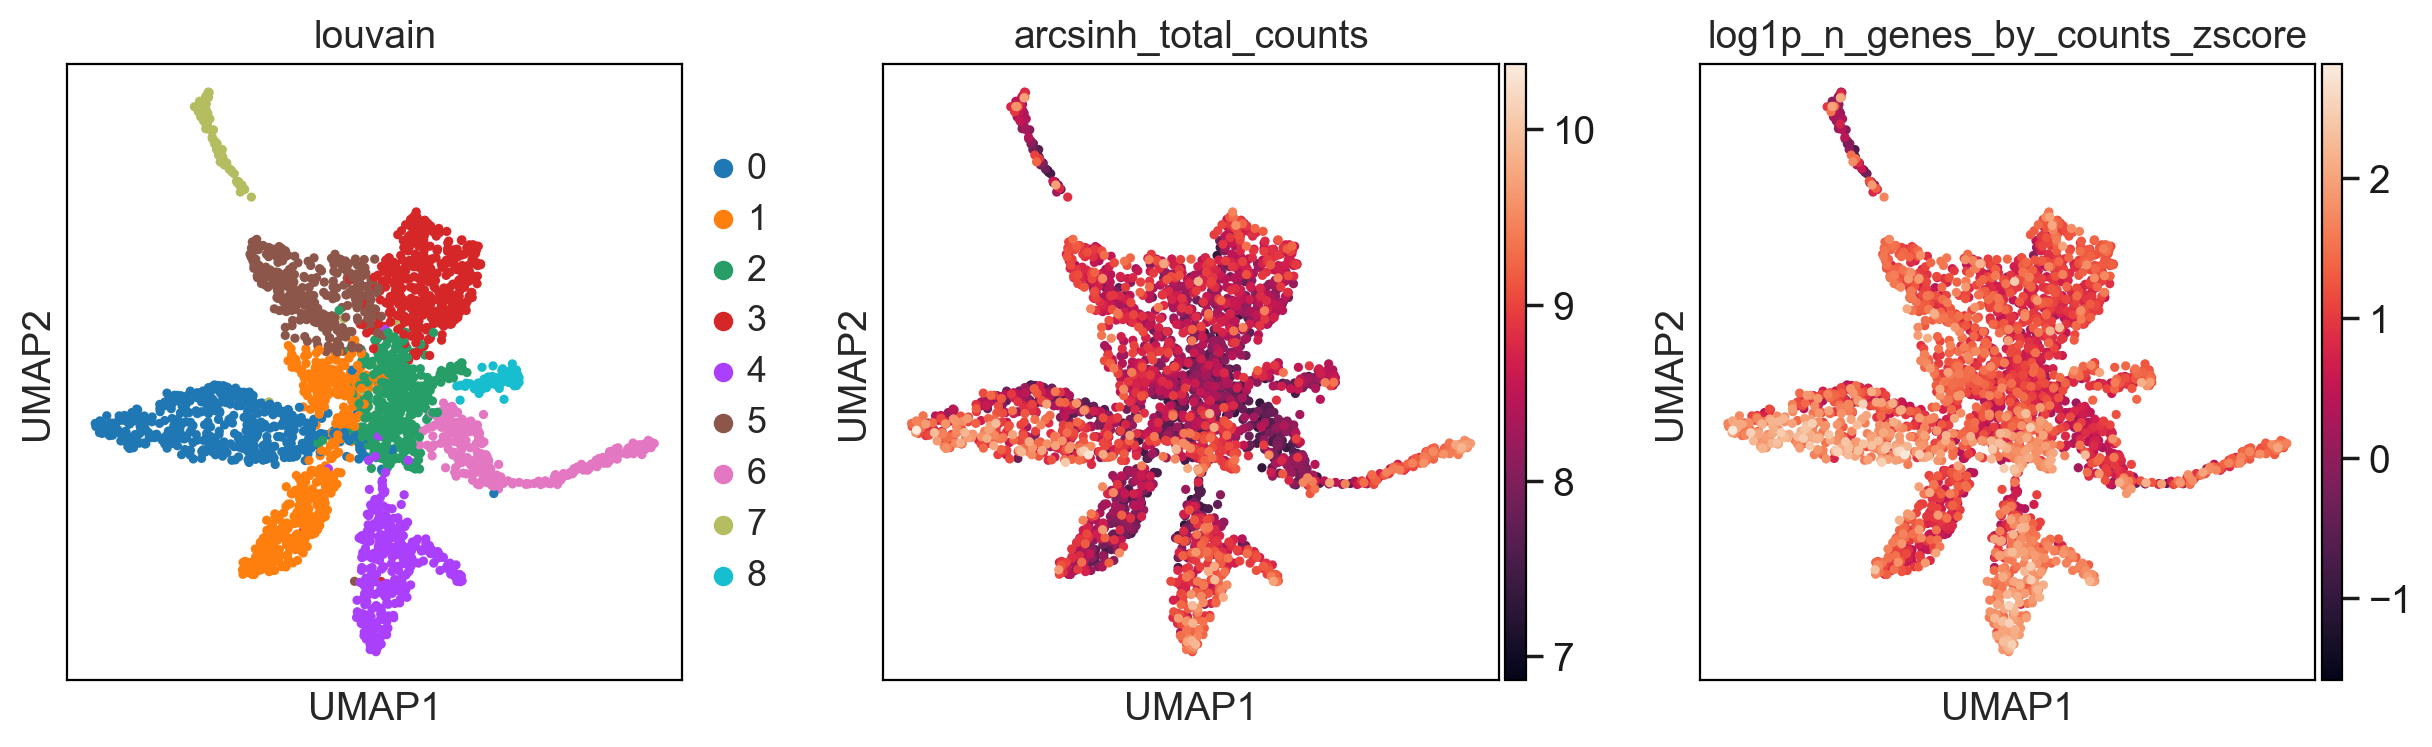

In [33]:
sc.pl.umap(s1_ken, color=['louvain','arcsinh_total_counts','log1p_n_genes_by_counts_zscore'])

In [43]:
s1_ken_clean = sc.AnnData(X=s1_ken.layers['raw_counts'])
s1_ken_clean.obs_names = s1_ken.obs_names
s1_ken_clean.var_names = s1_ken.var_names
s1_ken_clean

AnnData object with n_obs × n_vars = 2715 × 38459 

In [47]:
s1_ken_clean.write('../data/2771-AS-1-GCCAAT_S1_ken.h5ad', compression='gzip')

ValueError: Axis limits cannot be NaN or Inf

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

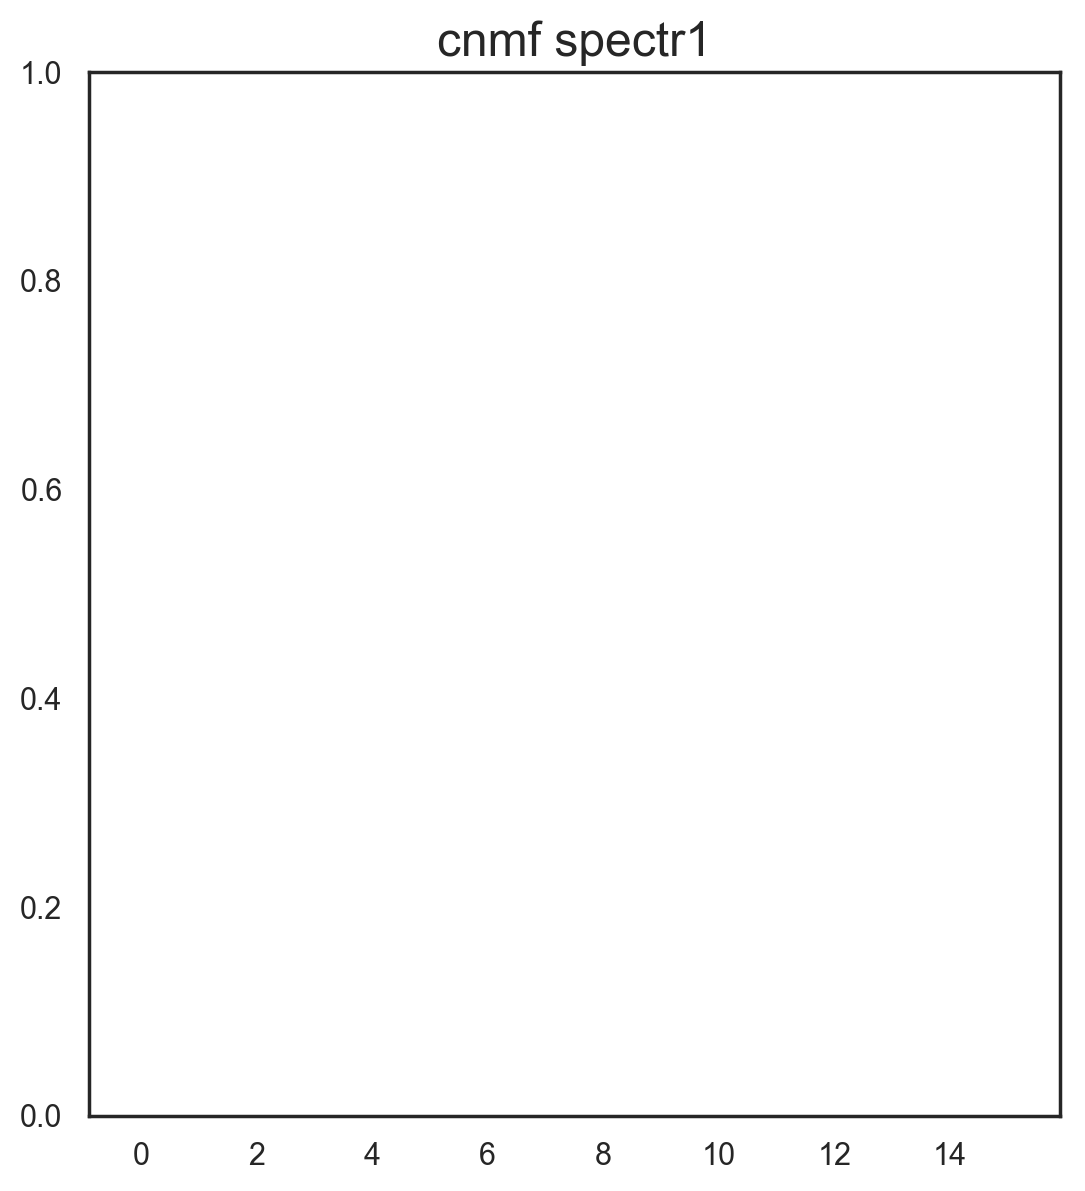

In [62]:
cnmf_load_results(s1_ken, '../cNMF', '2771_S1_ken', k=8, dt=0.1, key="cnmf", n_points=15)

In [63]:
s1_ken.uns['cnmf_markers'].head(10)

1         2        3       4       5        6        7       8
0  Thbs1      Agr2     Nkd1  Hbb-bt    C1qc   Jchain   S100a9   Lypd8
1   Il1a    Spink4     Wif1    Snca    Ctss     Igkc   Retnlg   Dmbt1
2   Sod2      Muc2   Spock2    Bpgm    C1qa    Ermap   S100a8    Muc3
3  Il1rn   Creb3l1      Mt3   Alas2    C1qb     Mzb1   Wfdc21    Krt8
4   Il1b   Hsd11b2      Ptn   Ntng1    Lyz2   Chmp4b    Cxcr2   Prdx6
5  Ptgs2     Sval1   Wnt10a  Hbb-bs  H2-Eb1     Igha  Alox5ap   Krt20
6   Ier3      Reg4  Tacstd2  Ube2l6   H2-Aa     Tff1   Ifitm6    Ly6a
7  Cxcl3  Hepacam2    Stra6  Hba-a1    Cd74  Slc7a14     Lcn2  Lgals4
8   Fth1      Oit1      Mgp  Hba-a2   Csf1r  Pou2af1     Mmp8   Muc13
9  Cxcl2      Fut2    Hspb1    Fech  H2-Ab1    Derl3     Lcp1   Gpa33

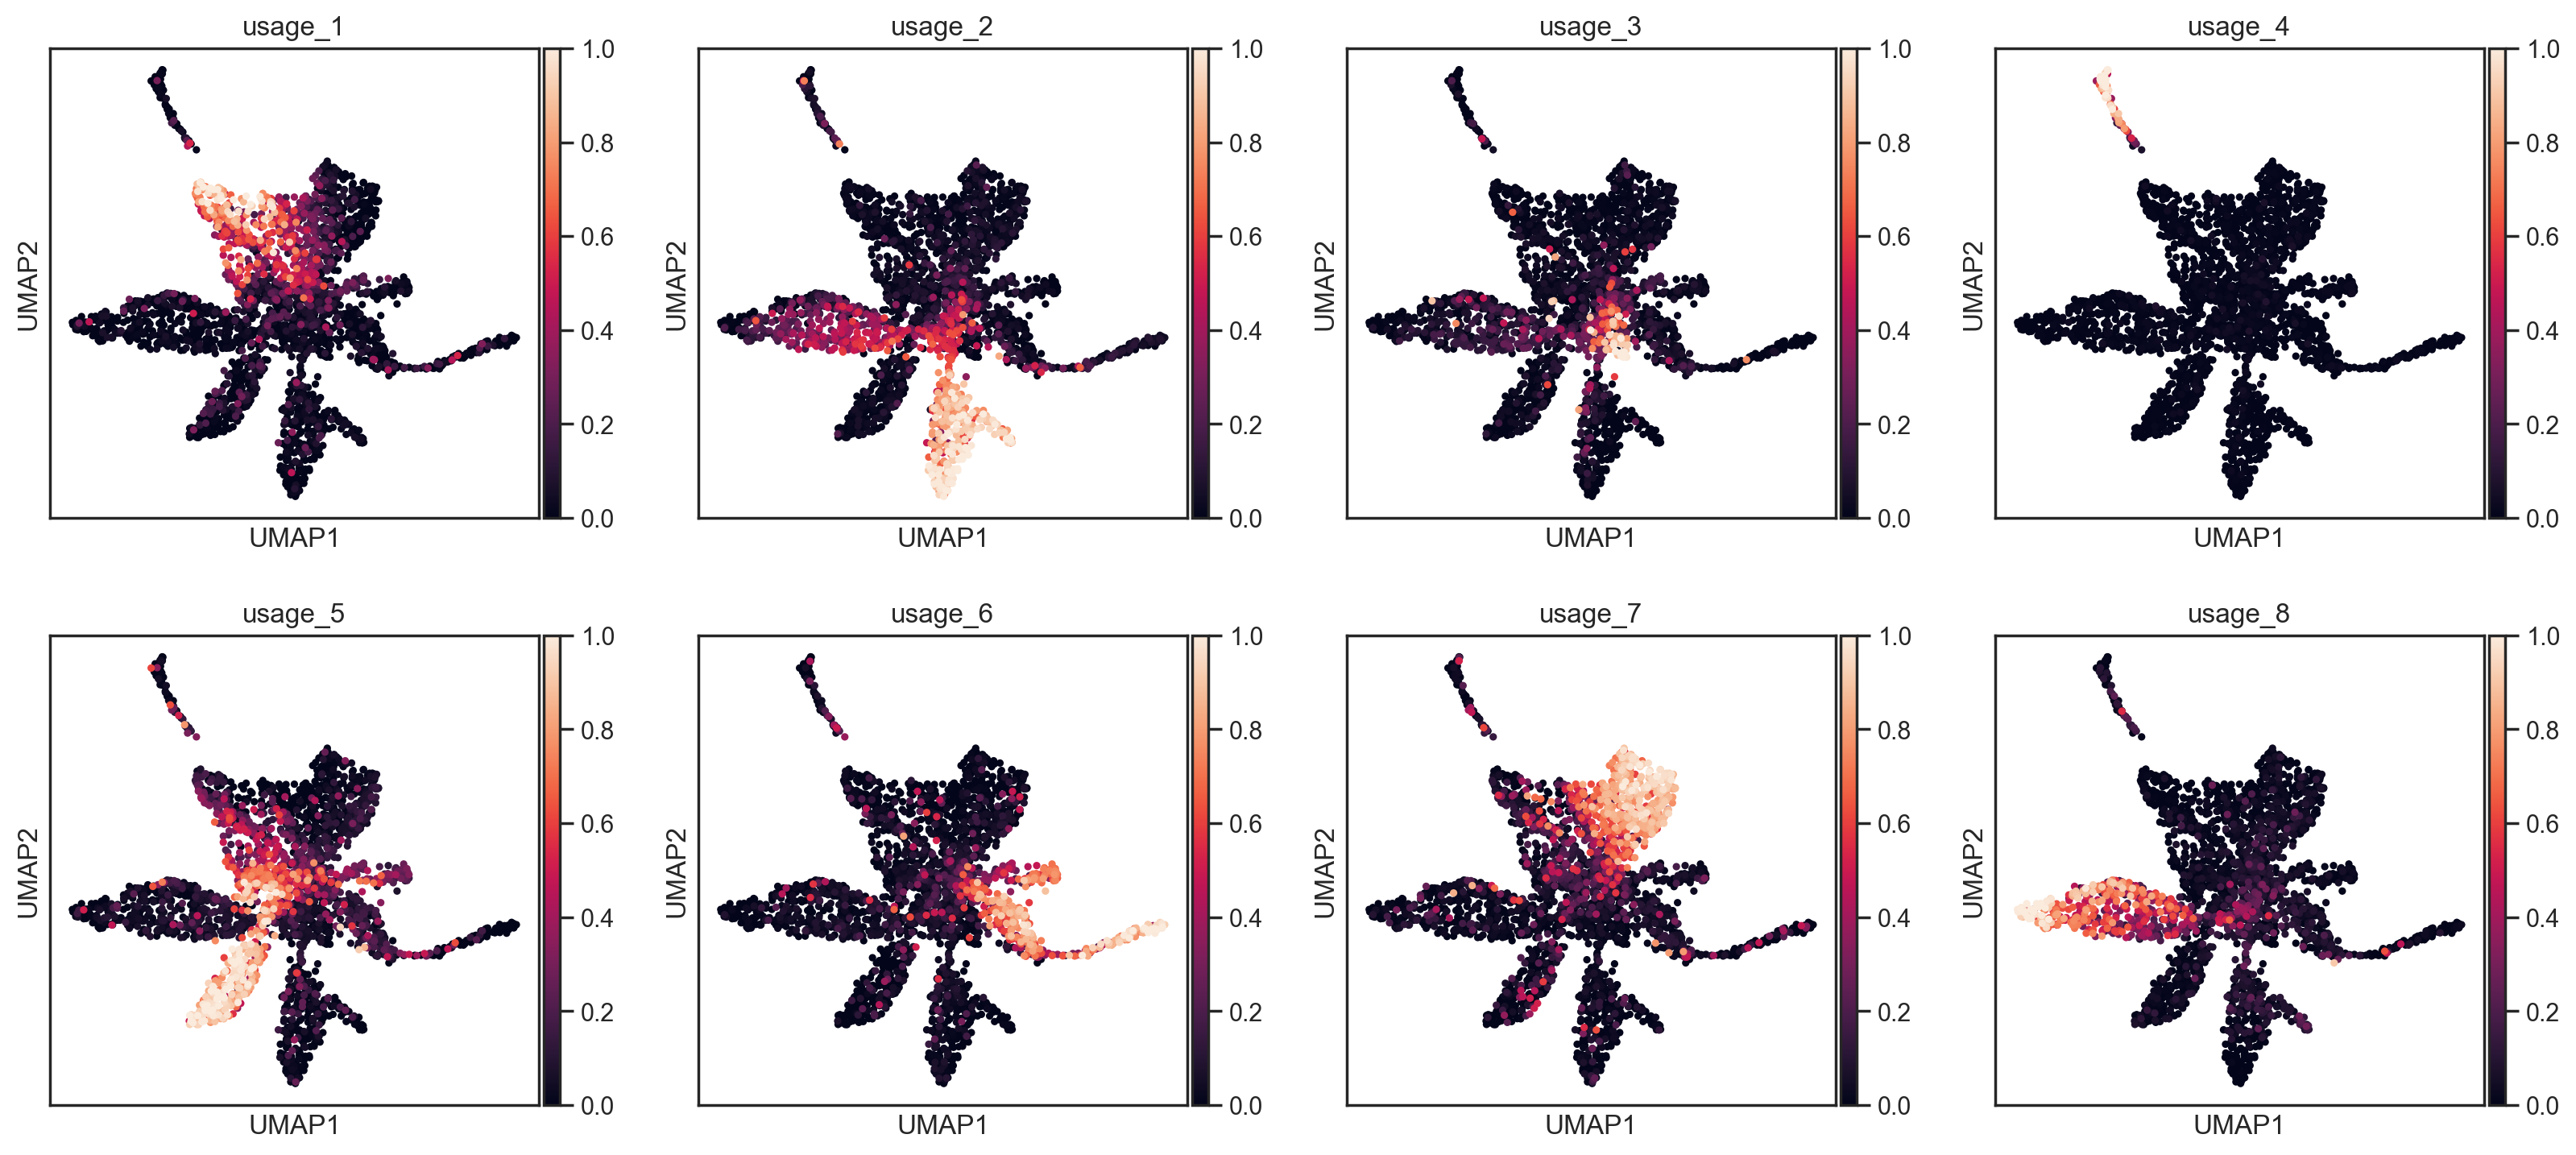

In [72]:
sc.pl.umap(s1_ken, color=['usage_1','usage_2','usage_3','usage_4','usage_5','usage_6','usage_7','usage_8'])

---
### Triple Threshold Filter

In [35]:
s1_thresh = s1[s1.obs['thresh_filter']==1,].copy()
s1_thresh

AnnData object with n_obs × n_vars = 3054 × 38459 
    obs: 'ken_filter', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'ranked_total_counts', 'arcsinh_total_counts', 'TPM_norm_factor', 'log1p_n_genes_by_counts_zscore', 'thresh_filter'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw_counts', 'arcsinh_norm', 'log1p_norm'

In [36]:
s1_thresh.X = s1_thresh.layers['raw_counts'].copy()
recipe_fcc(s1_thresh, mito_names="mt-")

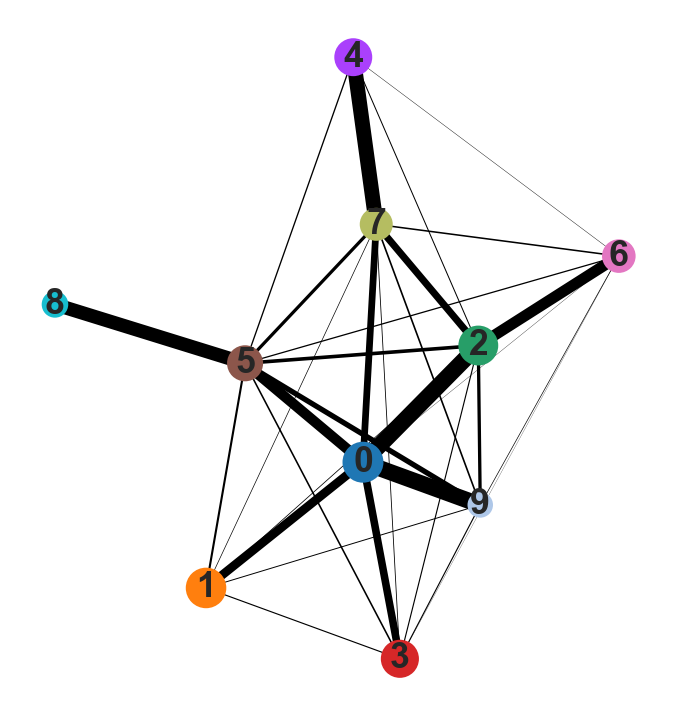

CPU times: user 4.22 s, sys: 995 ms, total: 5.21 s
Wall time: 1.81 s


In [37]:
%%time
sc.tl.pca(s1_thresh, n_comps=100)
sc.pp.neighbors(s1_thresh, n_neighbors=int(round(np.sqrt(s1_thresh.n_obs))), use_rep='X_pca', n_pcs=50, random_state=18)
sc.tl.louvain(s1_thresh, random_state=18)
sc.tl.paga(s1_thresh)
sc.pl.paga(s1_thresh, frameon=False)

In [38]:
sc.tl.umap(s1_thresh, init_pos=sc.tl._utils.get_init_pos_from_paga(s1_thresh))

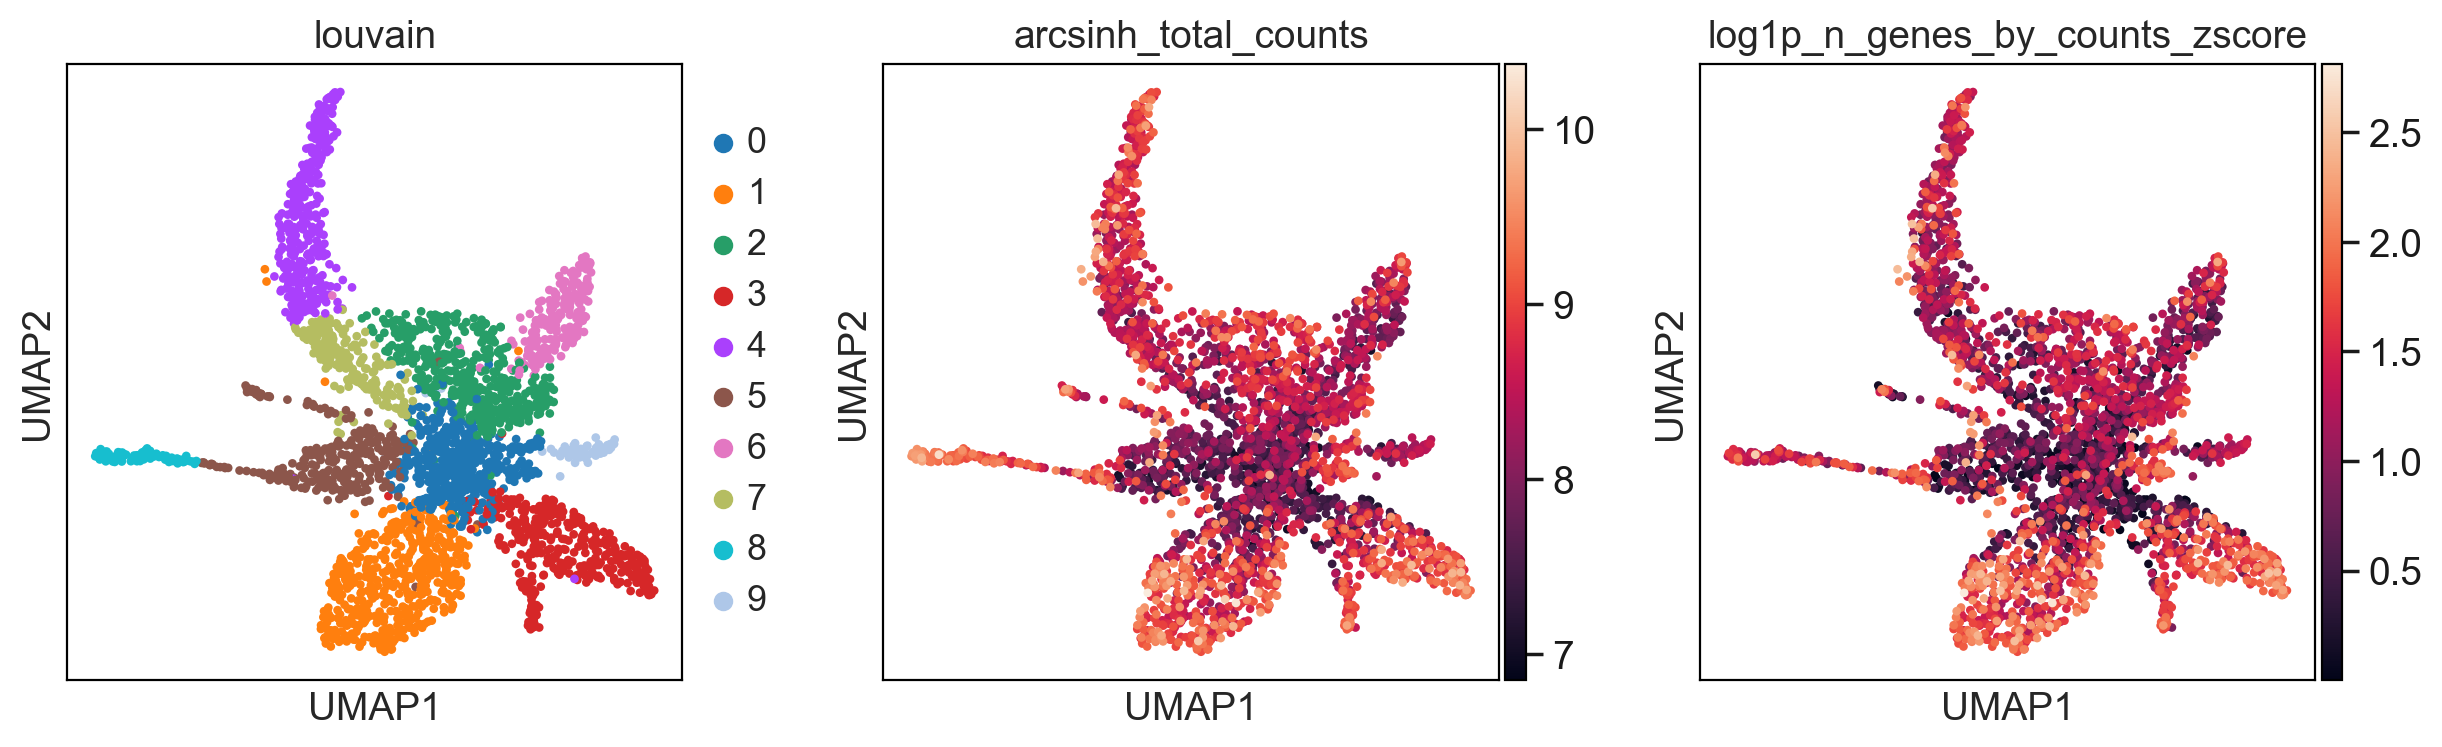

In [39]:
sc.pl.umap(s1_thresh, color=['louvain','arcsinh_total_counts','log1p_n_genes_by_counts_zscore'])

In [48]:
s1_thresh_clean = sc.AnnData(X=s1_thresh.layers['raw_counts'])
s1_thresh_clean.obs_names = s1_thresh.obs_names
s1_thresh_clean.var_names = s1_thresh.var_names
s1_thresh_clean

AnnData object with n_obs × n_vars = 3054 × 38459 

In [49]:
s1_thresh_clean.write('../data/2771-AS-1-GCCAAT_S1_triplethresh.h5ad', compression='gzip')

In [51]:
sys.path.append('/Users/cody/git/furry-couscous/')
from scanpy_utils import *

ValueError: Axis limits cannot be NaN or Inf

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

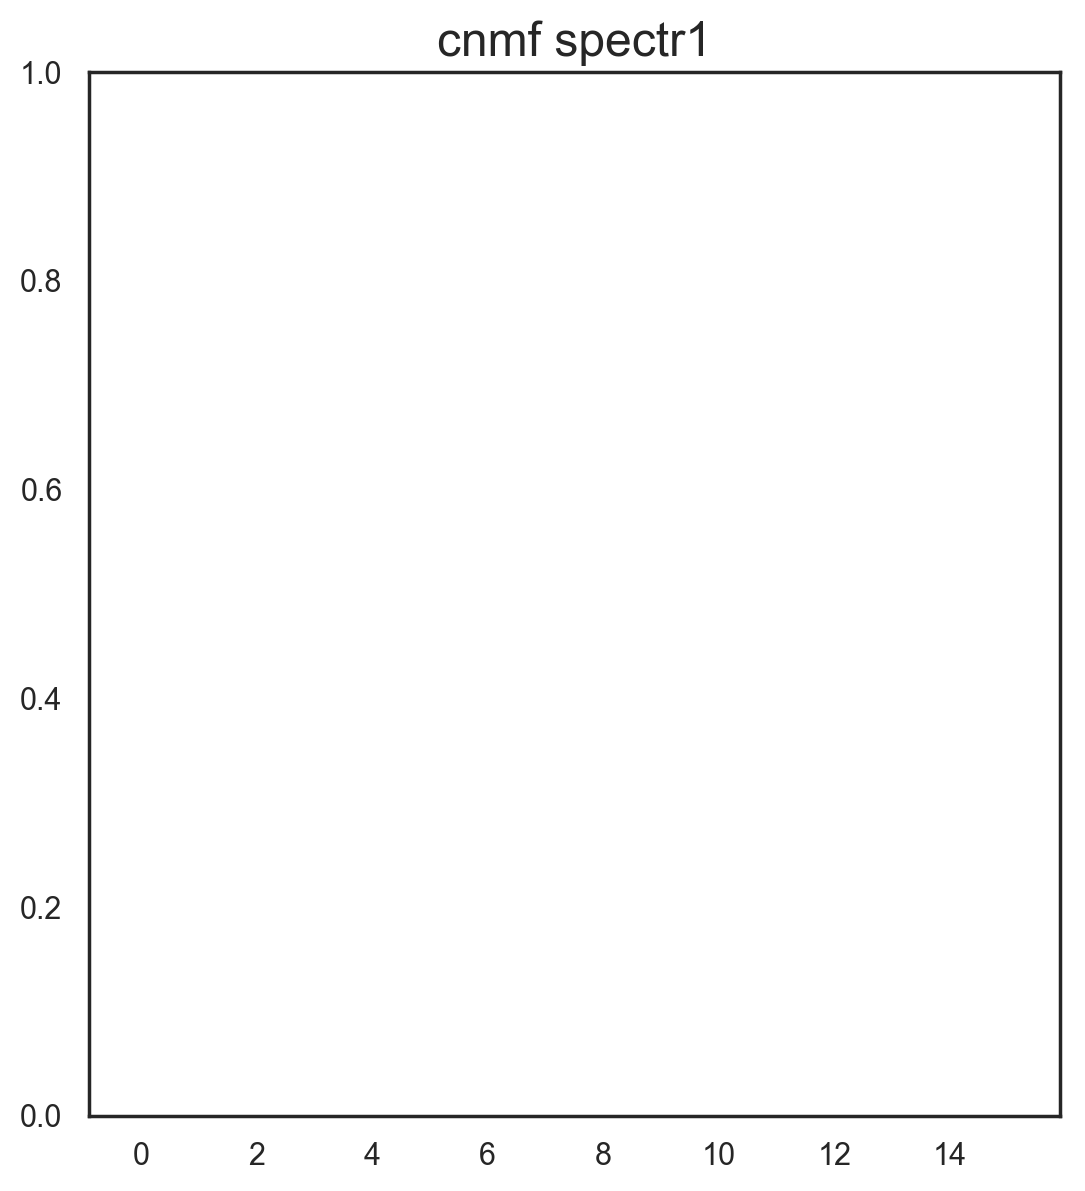

In [65]:
cnmf_load_results(s1_thresh, '../cNMF', '2771_S1_triplethresh', k=8, dt=0.1, key="cnmf", n_points=15)

In [66]:
s1_thresh.uns['cnmf_markers'].head(10)

1        2              3       4      5         6         7        8
0    Lypd8   S100a9         Hbb-bt    C1qc  Thbs1      Muc2      Ptma     Igkc
1    Dmbt1   S100a8         Hba-a2    C1qa   Il1a    Spink4     Tubb5   Jchain
2    Prdx6   Retnlg         Hbb-bs    C1qb  Il1rn      Agr2      Ppia    Ermap
3     Muc3   Wfdc21          Alas2    Ctss   Sod2     Sval1       Set     Igha
4    Krt20    Cxcr2          Ntng1  H2-Eb1  Ptgs2   Hsd11b2  Hsp90ab1     Mzb1
5     Krt8     Lcn2  1700007K13Rik   H2-Aa   Il1b      Klk1   Hnrnpab   Chmp4b
6  Sprr2a2   Ifitm6           Snca    Lyz2  Cxcl3      Reg4      Gpx2  Slc7a14
7     Ly6a  Alox5ap         Hba-a1    Cd74   Ier3      Tff3      Npm1     Tff1
8    Muc13     Mmp8           Bpgm    Apoe   Fth1  Hepacam2       Ran  Pou2af1
9   Lgals4     Lcp1         Slc4a1  H2-Ab1  Cxcl2     Gcnt3     Nedd4    Derl3

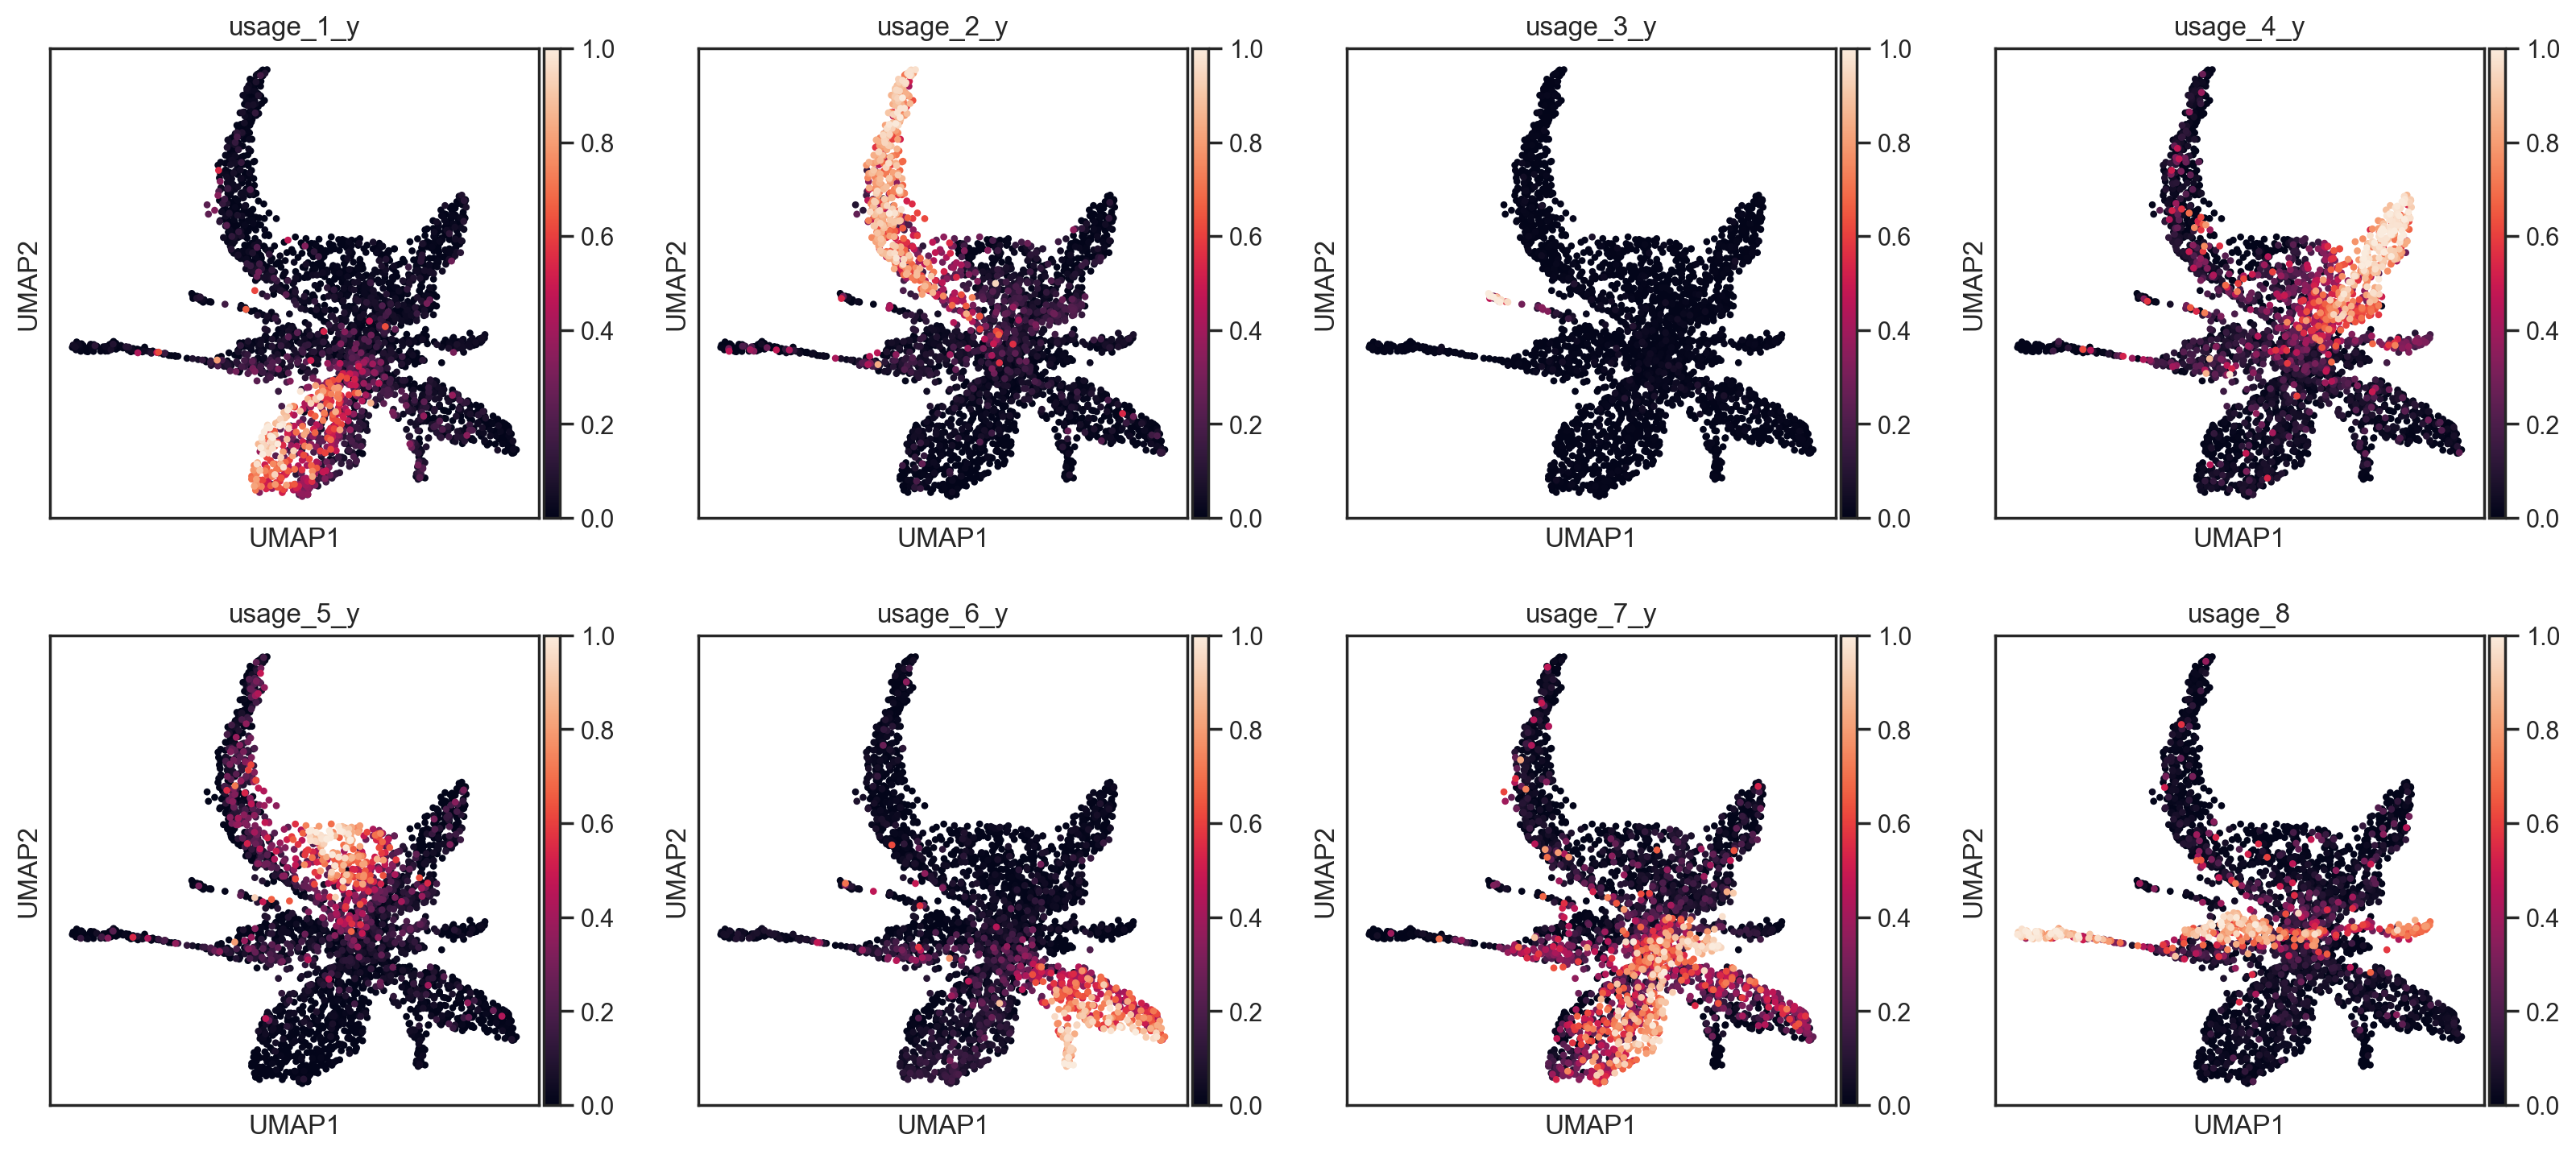

In [71]:
sc.pl.umap(s1_thresh, color=['usage_1_y','usage_2_y','usage_3_y','usage_4_y','usage_5_y','usage_6_y','usage_7_y','usage_8'])

---
Now, we want to generate a training set from the barcodes __below__ our `log1p_total_counts` threshold.  
To do so, we will randomly sample a reasonable number of barcodes (>1000), with probabilities __decreasing__ with __increasing total counts__.

In [16]:
# initialize 'probabilities' column with all zeros. we want probability of drawing a barcode ABOVE our threshold to be ZERO
s1.obs['counts_prob'] = 0

# of all the barcodes BELOW our threshold (using Li here), take the reciprocal of their total counts and normalize to the sum
s1.obs.loc[s1.obs['log1p_total_counts']<thresh_counts, 'counts_prob'] = np.reciprocal(s1.obs.loc[s1.obs['log1p_total_counts']<thresh_counts, 'total_counts']+1)
s1.obs['counts_prob'] /= s1.obs['counts_prob'].sum()

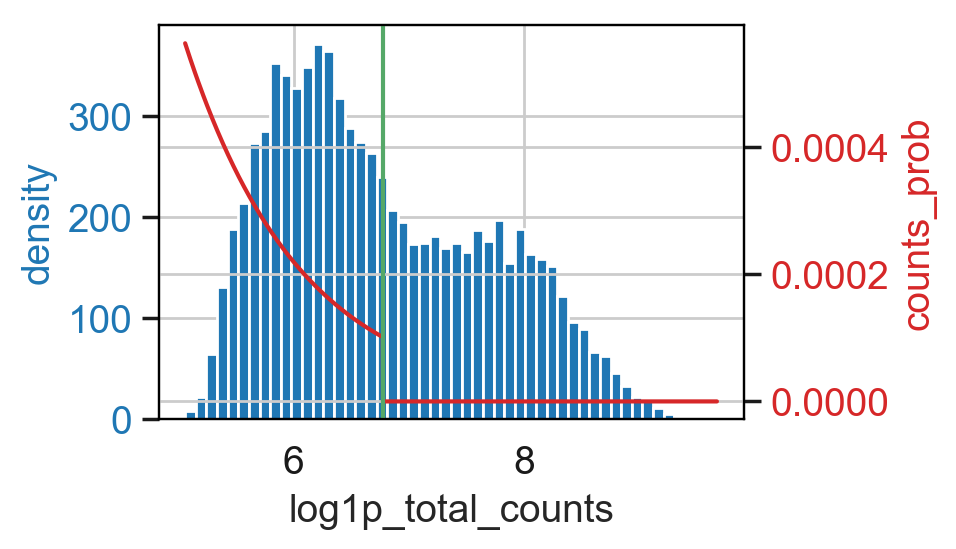

In [17]:
new_order = np.argsort(s1.obs['total_counts'])[::-1]
s1 = s1[new_order, :].copy()

# there should be a dropoff to ZERO at the threshold value we chose
fig, ax1 = plt.subplots(figsize=(5,3))

color = 'tab:blue'
ax1.set_xlabel('log1p_total_counts')
ax1.set_ylabel('density', color=color)
ax1.hist(s1.obs['log1p_total_counts'], bins=50, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('counts_prob', color=color)  # we already handled the x-label with ax1
ax2.plot(s1.obs['log1p_total_counts'], s1.obs['counts_prob'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.axvline(thresh_counts, color='g') # li threshold

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [18]:
# initialize 'probabilities' column with all zeros. we want probability of drawing a barcode ABOVE our threshold to be ZERO
s1.obs['genes_prob'] = 0

# of all the barcodes BELOW our threshold (using Li here), take the reciprocal of their total counts and normalize to the sum
s1.obs.loc[s1.obs['log1p_n_genes_by_counts']<thresh_genes, 'genes_prob'] = np.reciprocal(s1.obs.loc[s1.obs['log1p_n_genes_by_counts']<thresh_genes, 'log1p_n_genes_by_counts']+1)
s1.obs['genes_prob'] /= s1.obs['genes_prob'].sum()

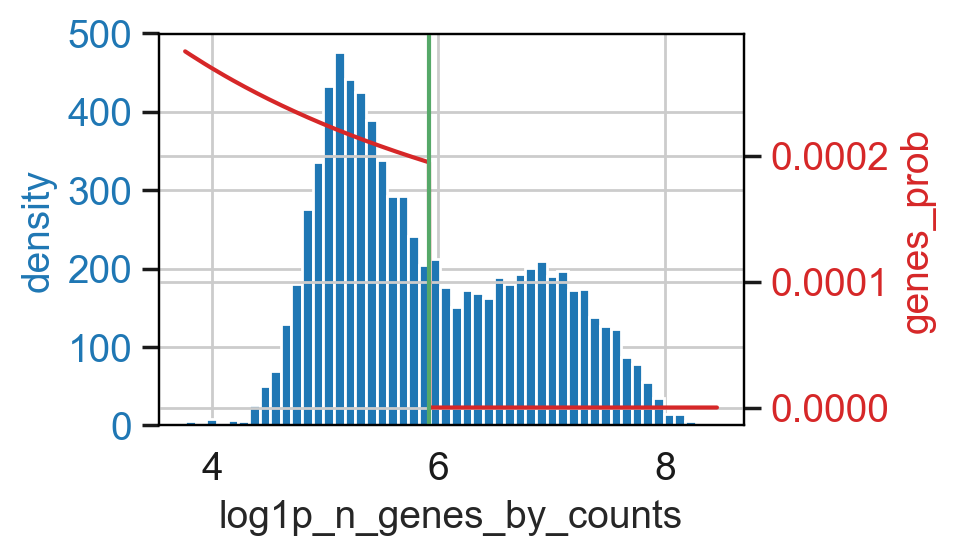

In [19]:
new_order = np.argsort(s1.obs['log1p_n_genes_by_counts'])[::-1]
s1 = s1[new_order, :].copy()

# there should be a dropoff to ZERO at the threshold value we chose
fig, ax1 = plt.subplots(figsize=(5,3))

color = 'tab:blue'
ax1.set_xlabel('log1p_n_genes_by_counts')
ax1.set_ylabel('density', color=color)
ax1.hist(s1.obs['log1p_n_genes_by_counts'], bins=50, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('genes_prob', color=color)  # we already handled the x-label with ax1
ax2.plot(s1.obs['log1p_n_genes_by_counts'], s1.obs['genes_prob'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.axvline(thresh_genes, color='g') # li threshold

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [20]:
# initialize 'probabilities' column with all zeros. we want probability of drawing a barcode ABOVE our threshold to be ZERO
s1.obs['mito_prob'] = 0

# of all the barcodes BELOW our threshold (using Li here), take the reciprocal of their total counts and normalize to the sum
s1.obs.loc[s1.obs['pct_counts_mito']>thresh_mito, 'mito_prob'] = s1.obs.loc[s1.obs['pct_counts_mito']>thresh_mito, 'pct_counts_mito']
s1.obs['mito_prob'] /= s1.obs['mito_prob'].sum()

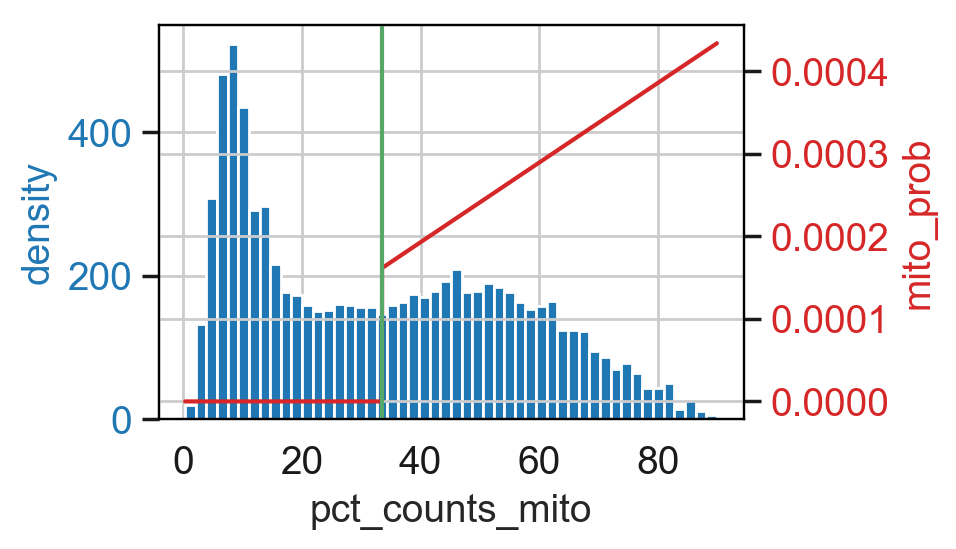

In [21]:
new_order = np.argsort(s1.obs['pct_counts_mito'])[:]
s1 = s1[new_order, :].copy()

# there should be a dropoff to ZERO at the threshold value we chose
fig, ax1 = plt.subplots(figsize=(5,3))

color = 'tab:blue'
ax1.set_xlabel('pct_counts_mito')
ax1.set_ylabel('density', color=color)
ax1.hist(s1.obs['pct_counts_mito'], bins=50, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('mito_prob', color=color)  # we already handled the x-label with ax1
ax2.plot(s1.obs['pct_counts_mito'], s1.obs['mito_prob'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.axvline(thresh_mito, color='g')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [22]:
s1.obs['train_prob'] = s1.obs['counts_prob'] + s1.obs['genes_prob'] + s1.obs['mito_prob']
s1.obs['train_prob'] /= s1.obs['train_prob'].sum()

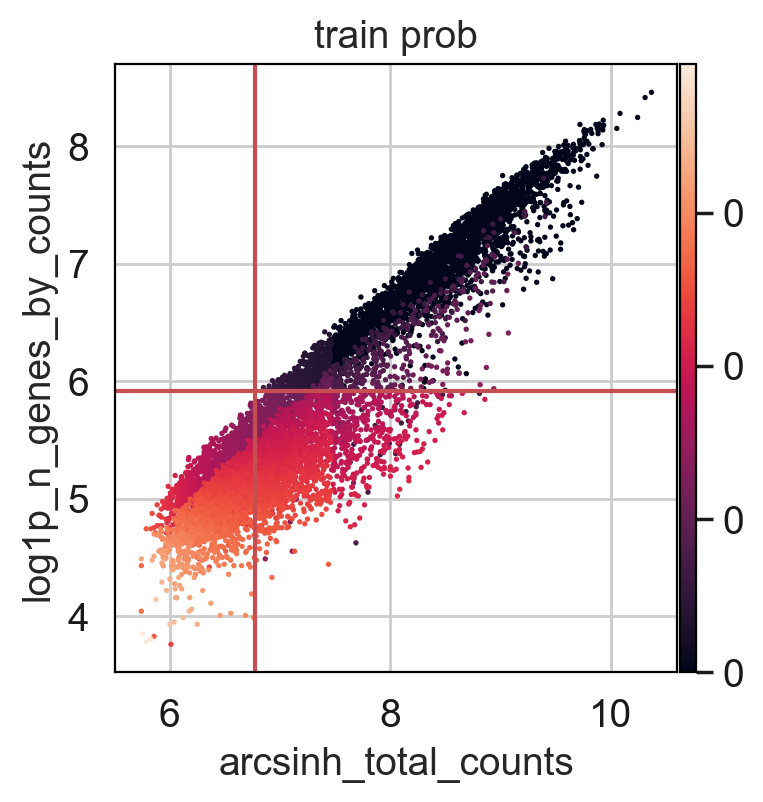

In [23]:
ax = sc.pl.scatter(adata=s1, y='log1p_n_genes_by_counts', x='arcsinh_total_counts', color='train_prob', show=False)
ax.axvline(thresh_counts, color='r')
ax.axhline(thresh_genes, color='r')
plt.show()

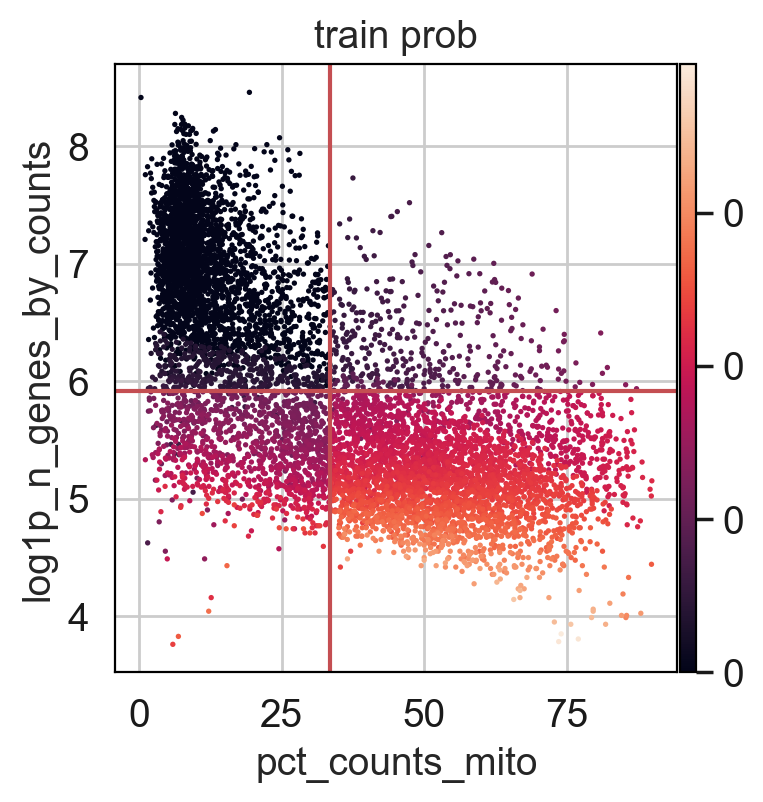

In [24]:
ax = sc.pl.scatter(adata=s1, y='log1p_n_genes_by_counts', x='pct_counts_mito', color='train_prob', show=False)
ax.axvline(thresh_mito, color='r')
ax.axhline(thresh_genes, color='r')
plt.show()

In [25]:
s1

AnnData object with n_obs × n_vars = 8064 × 38459 
    obs: 'ken_filter', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'ranked_total_counts', 'arcsinh_total_counts', 'TPM_norm_factor', 'thresh_filter', 'counts_prob', 'genes_prob', 'mito_prob', 'train_prob'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw_counts', 'arcsinh_norm', 'log1p_norm'

In [26]:
# now randomly sample a training set using s1.obs['train_prob'] from above as the vector of probabilities.
# save sample as label in adata.obs['train']
s1.obs['train'] = 0
s1.obs.iloc[np.random.choice(a=s1.obs.shape[0], size=1000, replace=False, p=s1.obs['train_prob']),s1.obs.columns.get_loc('train')] = 1

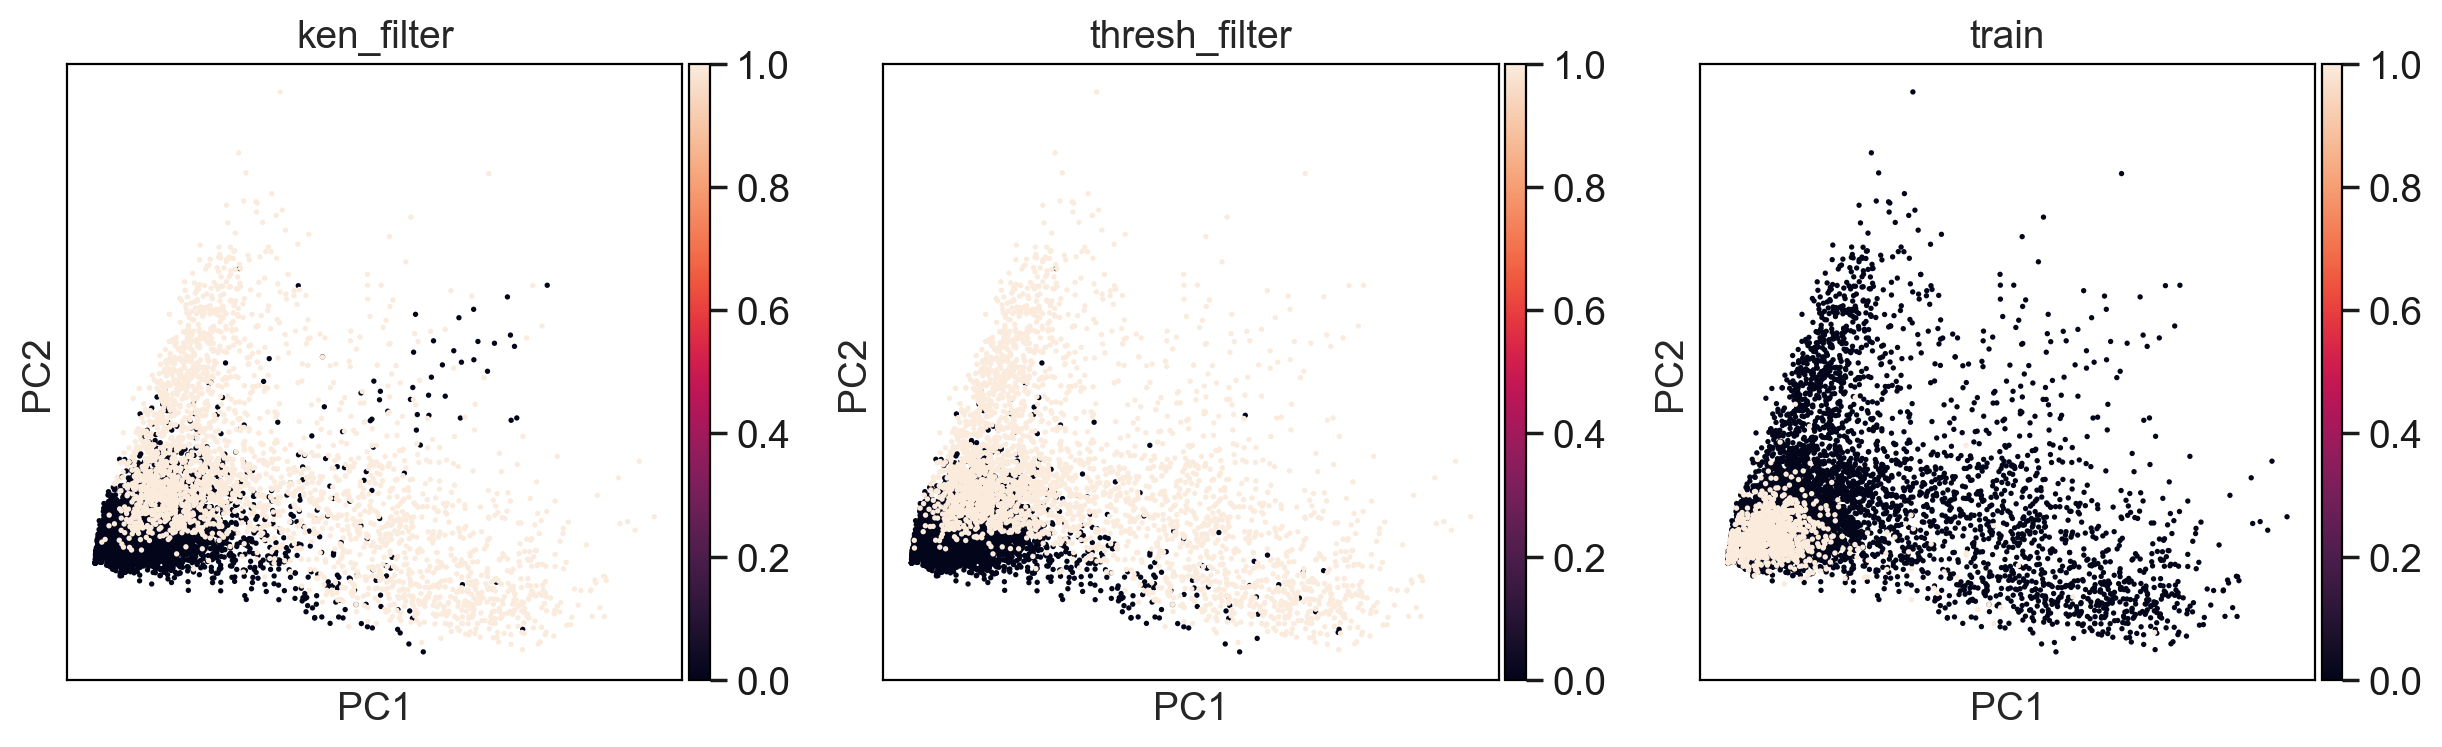

In [27]:
sc.pl.pca(s1, color=['ken_filter','thresh_filter','train'])

Compare our training set to Ken's filter.  
We want a small number here, but <= 50 is acceptable, since our machine learning classifier will work out the kinks...

In [28]:
len(set(s1.obs.loc[s1.obs['train']==1].index).difference(set(s1.obs.loc[s1.obs['thresh_filter']==0].index)))

23

In [29]:
len(set(s1.obs.loc[s1.obs['train']==1].index).difference(set(s1.obs.loc[s1.obs['ken_filter']==0].index)))

22

In [30]:
# define X and y for classifier training for simplicity
X = s1.obsm['X_pca'] # training data is PCA results
y = s1.obs['train'].copy(deep=True) # training labels are from .obs df

In [ ]:
%%time
bc = BaggingClassifierPU(
    LogisticRegressionCV(cv=5, random_state=0, multi_class='multinomial', max_iter=1000), 
    n_estimators = 1000,  # 1000 trees as usual
    max_samples = sum(y), # Balance the positives and unlabeled in each bag
    n_jobs = -1           # Use all cores
)
bc.fit(X, y)

results_bagging_empty = bc.oob_decision_function_[:,1]

In [ ]:
s1.obs['bag_decision_function'] = bc.oob_decision_function_[:,1]
s1.obs['bag_filter'] = bc.predict(X)

In [ ]:
sc.pl.pca(s1, color=['ken_filter','thresh_filter','train','bag_decision_function','bag_filter'])

---
### Bagging Decision Tree Classifier

In [157]:
s1_bag = s1[s1.obs['bag_filter']==0,].copy()
s1_bag

AnnData object with n_obs × n_vars = 4532 × 38459 
    obs: 'ken_filter', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'ranked_total_counts', 'arcsinh_total_counts', 'TPM_norm_factor', 'log1p_n_genes_by_counts_zscore', 'thresh_filter', 'counts_prob', 'genes_prob', 'mito_prob', 'train_prob', 'train', 'bag_filter'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw_counts', 'arcsinh_norm', 'log1p_norm'

In [158]:
s1_bag.X = s1_bag.layers['raw_counts'].copy()
sc.pp.filter_genes(s1_bag, min_cells=1)
recipe_fcc(s1_bag, mito_names="mt-")

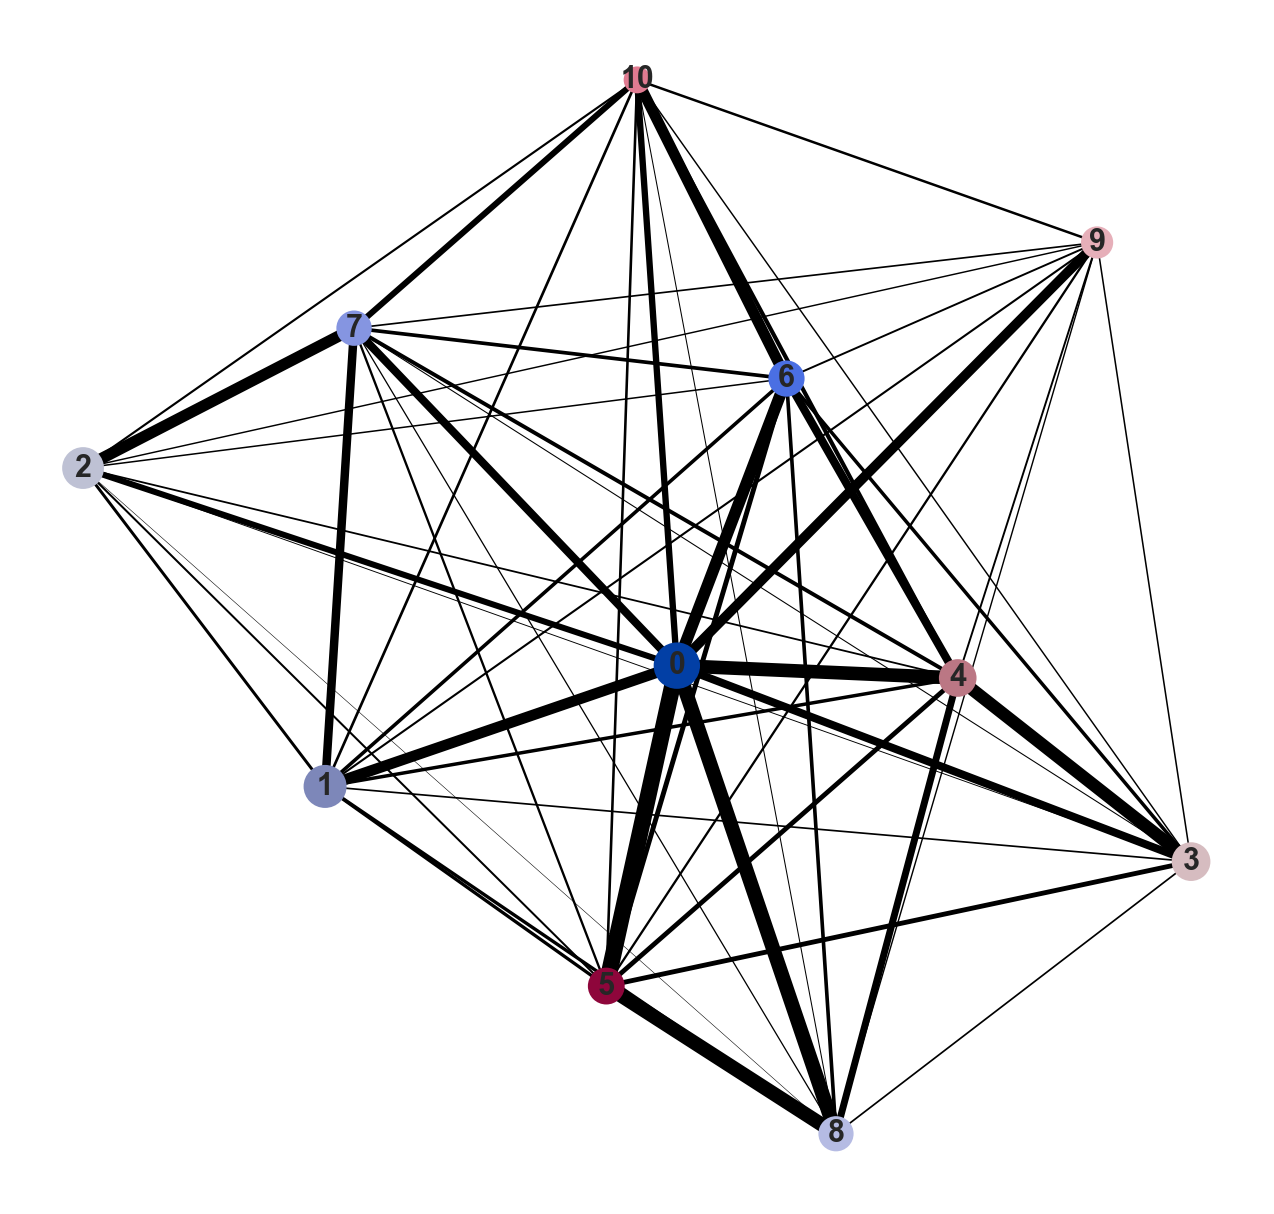

CPU times: user 7.84 s, sys: 920 ms, total: 8.76 s
Wall time: 3.67 s


In [159]:
%%time
sc.tl.pca(s1_bag, n_comps=100)
sc.pp.neighbors(s1_bag, n_neighbors=int(round(np.sqrt(s1_bag.n_obs))), use_rep='X_pca', n_pcs=50, random_state=18)
sc.tl.louvain(s1_bag, random_state=18)
sc.tl.paga(s1_bag)
sc.pl.paga(s1_bag, frameon=False)

In [160]:
sc.tl.umap(s1_bag, init_pos=sc.tl._utils.get_init_pos_from_paga(s1_bag))

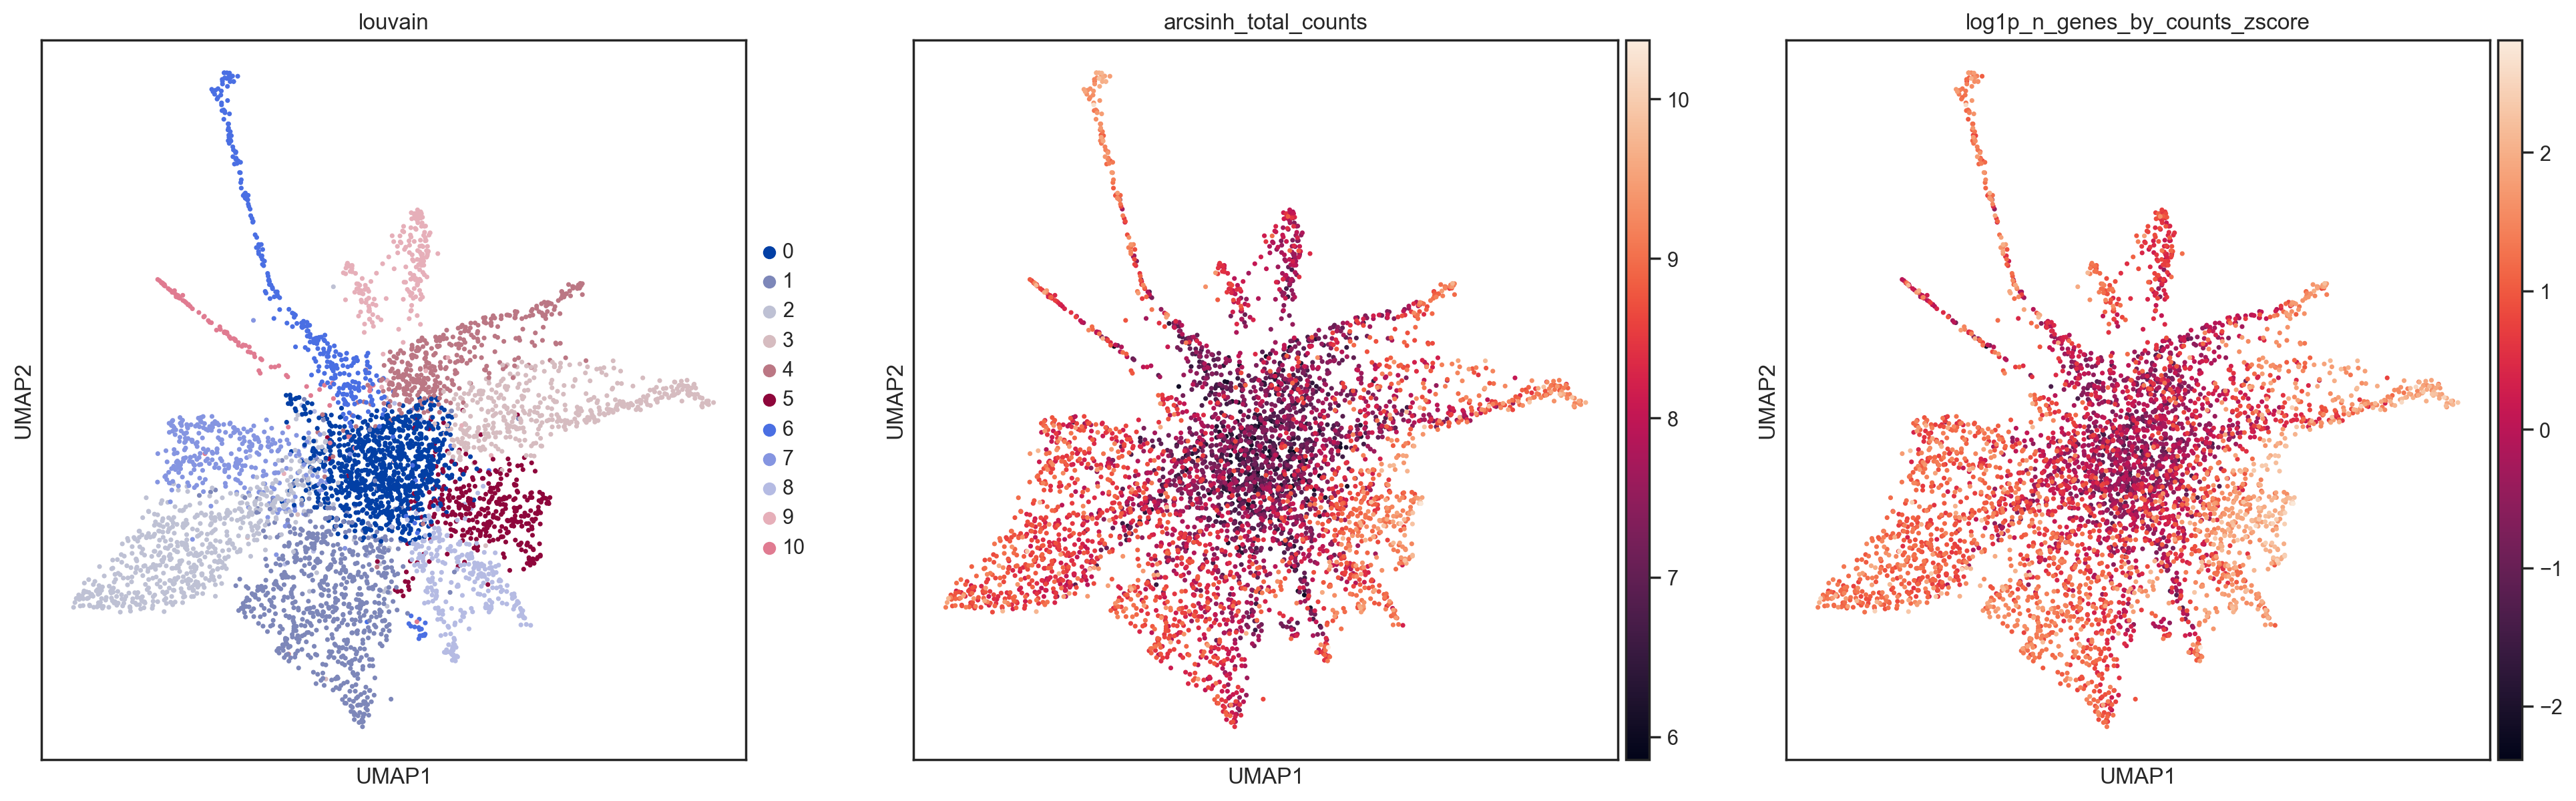

In [161]:
sc.pl.umap(s1_bag, color=['louvain','arcsinh_total_counts','log1p_n_genes_by_counts_zscore'])

In [162]:
s1_bag_clean = sc.AnnData(X=s1_bag.layers['raw_counts'])
s1_bag_clean.obs_names = s1_bag.obs_names
s1_bag_clean.var_names = s1_bag.var_names
s1_bag_clean

AnnData object with n_obs × n_vars = 4532 × 27505 

In [163]:
s1_bag_clean.write('../data/2771-AS-1-GCCAAT_S1_triplethreshbagging.h5ad', compression='gzip')